In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# ONLY THING YOU SHOULD CHANGE -----
df = pd.read_csv('soak-get-recommendations-script.csv')
request_name = "Soak - Get Recommendations"
# -----------------------------------

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df.head()

In [34]:
len(df)
df.columns

Index(['metric_name', 'timestamp', 'metric_value', 'check', 'error',
       'error_code', 'expected_response', 'group', 'method', 'name', 'proto',
       'scenario', 'service', 'status', 'subproto', 'tls_version', 'url',
       'extra_tags', 'metadata'],
      dtype='object')

In [35]:
timestamp_column = 'timestamp'
df[timestamp_column] = pd.to_datetime(df[timestamp_column])
df['seconds'] = (df[timestamp_column] - df[timestamp_column].iloc[0]).dt.total_seconds()

columns_to_drop = ['check', 'error', 'error_code', 'timestamp', 'group', 'service', 'subproto', 'tls_version', 'extra_tags', 'metadata']  # List of columns you want to drop
df.drop(columns=columns_to_drop, inplace=True)
df.isnull().sum()


metric_name                 0
metric_value                0
expected_response    42626416
method               42626416
name                 42626416
proto                42626416
scenario                87600
status               42626416
url                  42626416
seconds                     0
dtype: int64

In [36]:
# Clean up Nans
def convert_to_seconds(value):
    return value * 1e9

# Apply the function to the 'seconds' column
df['seconds'] = df['seconds'].apply(convert_to_seconds)


certain_names = ['data_sent', 'iteration_duration', 'iterations', 'data_received']
withHTTP_df = df[~df['metric_name'].isin(certain_names)] # Removing these as its not needed right now
withoutHTTP_unfiltered_df = df[df['metric_name'].isin(certain_names)]
withoutHTTP_df = withoutHTTP_unfiltered_df[['metric_name', 'seconds', 'metric_value']] # Keep Relevent ones

In [37]:
http_req_duration_df = withHTTP_df[withHTTP_df["metric_name"] == "http_req_duration"]
vus_df = withHTTP_df[withHTTP_df["metric_name"] == "vus"]
http_req_failed_df = withHTTP_df[withHTTP_df["metric_name"] == "http_req_failed"]
http_reqs_df = withHTTP_df[withHTTP_df["metric_name"] == "http_reqs"]

In [ ]:
withHTTP_df.head(100)

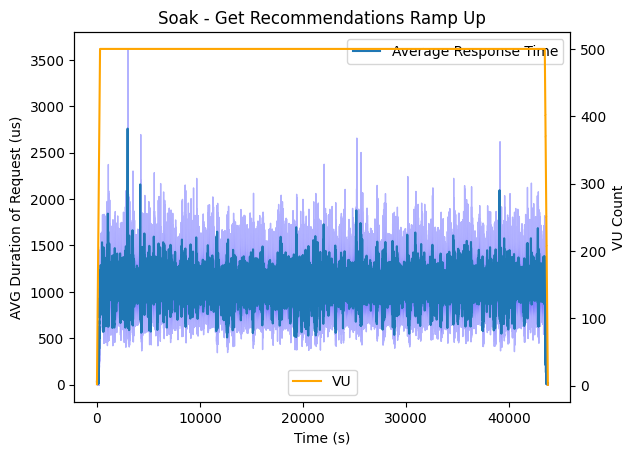

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'seconds' and calculate the average of 'metric_value'
avg_metric_values = http_req_duration_df.groupby('seconds')['metric_value'].agg(['mean', 'std']).reset_index()

sns.lineplot(x='seconds', y='mean', data=avg_metric_values, label='Average Response Time')
plt.fill_between(avg_metric_values['seconds'], avg_metric_values['mean'] - avg_metric_values['std'],
                 avg_metric_values['mean'] + avg_metric_values['std'], color='blue', alpha=0.3)
plt.ylabel('AVG Duration of Request (us)')
plt.xlabel('Time (s)')
plt.twinx()

sns.lineplot(x=vus_df['seconds'], y=vus_df['metric_value'], label='VU', color='orange')
plt.ylabel('VU Count')
plt.title(f'{request_name} Ramp Up')
plt.xlabel('Time (s)')
plt.show()

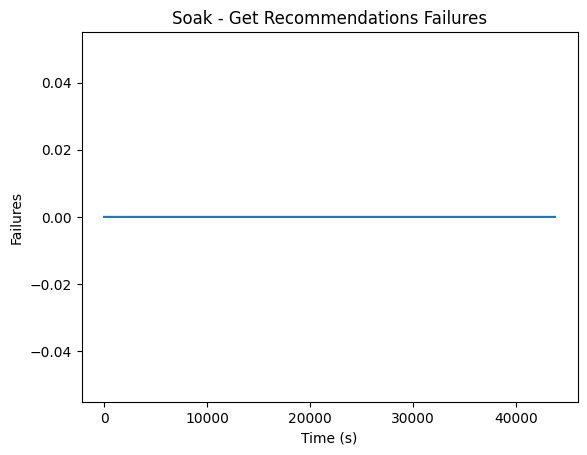

In [40]:
http_req_failed_df.head()

failures_sum = http_req_failed_df.groupby('seconds')['metric_value'].sum().reset_index()

# Plot the sum of failures over time
sns.lineplot(x=failures_sum['seconds'], y=failures_sum['metric_value'])
plt.xlabel('Time (s)')
plt.ylabel('Failures')
plt.title(f'{request_name} Failures')
plt.show()

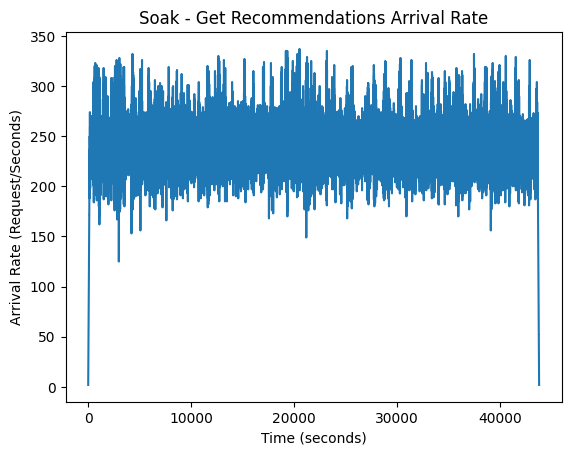

In [41]:
ar = http_req_duration_df.groupby('seconds').size()
sns.lineplot(x=ar.index, y=ar.values)
plt.xlabel('Time (seconds)')
plt.ylabel('Arrival Rate (Request/Seconds)')
plt.title(f'{request_name} Arrival Rate')
plt.show()

In [42]:
from scipy.stats import t

# vus_df['seconds'], y=vus_df['metric_value']

# Calculate sample statistics
sample_mean = avg_metric_values['mean'].mean()
sample_std = avg_metric_values['std'].mean()
sample_size = len(df)

# Set the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the critical value (for t-distribution)
degrees_of_freedom = sample_size - 1
critical_value = t.ppf((1 + confidence_level) / 2, df=degrees_of_freedom)

# Calculate margin of error
margin_of_error = critical_value * (sample_std / np.sqrt(sample_size))

# Calculate confidence intervals
lower_bound = sample_mean - margin_of_error
upper_bound = sample_mean + margin_of_error

# Display the results
print(f"Confidence interval for '{request_name}' the mean: ({lower_bound}, {upper_bound})")

Confidence interval for 'Soak - Get Recommendations' the mean: (1046.444413155655, 1046.53191379937)


In [43]:
avg_metric_values.describe()

,seconds,mean,std
count,43800.000000,43800.000000,43800.000000
mean,21899.500000,1046.488163,262.545805
std,12644.115232,160.059526,73.432165
min,0.000000,8.163155,0.554154
25%,10949.750000,990.795145,224.059635
50%,21899.500000,1055.882723,263.289261
75%,32849.250000,1124.459604,302.485651
max,43799.000000,2759.594375,858.655789


/var/folders/tv/prbv6r_92bj5f996988__8jh0000gn/T/ipykernel_3104/701658553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  http_req_duration_df['request_duration'] = df['metric_value'].apply(from_micro_convert_to_seconds)
/var/folders/tv/prbv6r_92bj5f996988__8jh0000gn/T/ipykernel_3104/701658553.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  http_req_duration_df['request_end'] = http_req_duration_df[['request_duration', 'seconds']].sum(axis=1)
/var/folders/tv/prbv6r_92bj5f996988__8jh0000gn/T/ipyker

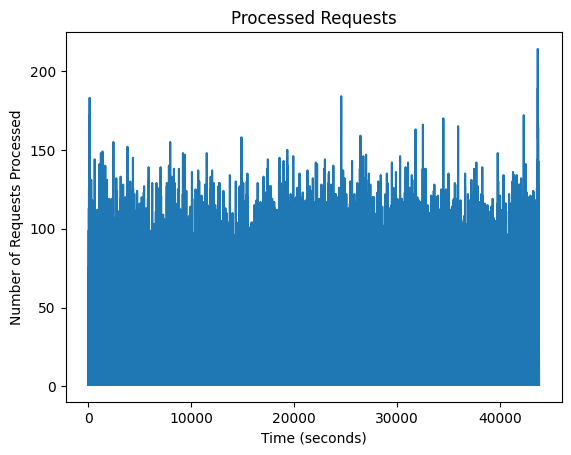

In [44]:
# ar = http_req_duration_df.groupby('seconds').mean()
# sns.lineplot(x=ar.index, y=1/(ar.metric_value))
# plt.xlabel('Time (seconds)')
# plt.ylabel('Throughput (Request/Seconds)')
# plt.title(f'{request_name} Throughput')
# plt.show()

def from_micro_convert_to_seconds(value):
    return value / 1e6

# Apply the function to the 'seconds' column
http_req_duration_df['request_duration'] = df['metric_value'].apply(from_micro_convert_to_seconds)
http_req_duration_df.head()

http_req_duration_df['request_end'] = http_req_duration_df[['request_duration', 'seconds']].sum(axis=1)

# Round 'request_end' to the nearest thousandth
http_req_duration_df['request_end_rounded'] = http_req_duration_df['request_end'].round(5)

# Count the occurrences of each rounded value
request_counts = http_req_duration_df['request_end_rounded'].value_counts().sort_index()

# Plot the request counts against 'seconds'
plot_data = pd.DataFrame({'Time (seconds)': request_counts.index, 'Number of Requests': request_counts.values})

# Plot using Seaborn
sns.lineplot(data=plot_data, x='Time (seconds)', y='Number of Requests', linestyle='-')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Requests Processed')
plt.title('Processed Requests')
plt.show()

/var/folders/tv/prbv6r_92bj5f996988__8jh0000gn/T/ipykernel_3104/657703495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  http_req_duration_df['Time (seconds)'] = pd.to_datetime(http_req_duration_df['request_end_rounded'], unit='s')
/var/folders/tv/prbv6r_92bj5f996988__8jh0000gn/T/ipykernel_3104/657703495.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  requests_per_second = http_req_duration_df.resample('0.5S').size()


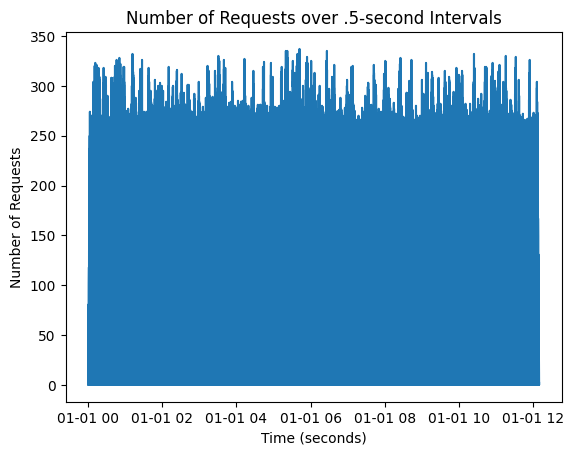

In [45]:
http_req_duration_df['Time (seconds)'] = pd.to_datetime(http_req_duration_df['request_end_rounded'], unit='s')
http_req_duration_df.set_index('Time (seconds)', inplace=True)
requests_per_second = http_req_duration_df.resample('0.5S').size()
plt.plot(requests_per_second.index, requests_per_second.values, linestyle='-')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Requests')
plt.title('Number of Requests over .5-second Intervals')
plt.show()